In [54]:
import cv2
import numpy as np
import pandas as pd
import numpy as np
from PIL import Image
#from resizeimage import resizeimage
import os
import re
import matplotlib
from matplotlib.pyplot import imshow
from scipy.misc import imread, imresize
from matplotlib import pyplot as plt

In [26]:
def convertToRGB(img): 
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [2]:
# working directory 설정해서 사용하기
path = "./Downtowner_Burger/"
os.chdir(path)
print(os.getcwd())

/Users/haewonpark/Projects/handson/Image_Clustering_ORB/Downtowner_Burger


In [3]:
# resize 해주고 비교하는것이 원본 그대로 비교하는 것보다 성능이 더 좋음을 확인, 속도도 훨씬 몇배로 빠르다
width = 220 
height = 220 # resize 해줄 가로, 세로 크기
ext='.jpeg' # 일괄적으로 확장자를 설정해 줄 예정

In [4]:
# jjung : 아래코드 대신 정규표현식을 사용해서 파일이름 효율적으로 변환하는 방법
import re

# 전부 동일한 확장자 명으로 바꿔주기
pattern = re.compile("(.jpg)$", re.IGNORECASE) # .JPG  나 .jpg로 끝나는 패턴, ignorecase option을 붙이면 대소문자 구분없게 해주기 때문에 사실 jpg하나만 써주면 됨
for fileName in os.listdir("."):
    check = pattern.search(fileName)
    if check :
        text_to_replace = check.group()
        os.rename(fileName, fileName.replace(text_to_replace, ext))

# 이름 첫부분에 0이 하나이상 들어가는 것 바꿔주기 
pattern  = re.compile("^[0]+") # 첫부분에 0이 하나이상 반복되는 패턴
for fileName in os.listdir("."):
    check = pattern.search(fileName)
    if check :
        num_0 = check.end()
        os.rename(fileName, fileName[num_0:])
        
pattern = re.compile("(.png|.GIF)$",re.IGNORECASE)
for fileName in os.listdir("."):
    check=pattern.search(fileName)
    if check:
        im = Image.open(fileName)
        rgb_im = im.convert('RGB')
        rgb_im.save(fileName[:-4]+ext)
        os.remove(fileName) 


In [5]:
#이미 만들어진 resize 이미지 일괄 삭제
for fileName in os.listdir('.') :
    if fileName.startswith("resize") : os.remove(fileName) 

In [7]:
len(os.listdir('.'))

744

In [15]:
# 폴더에 있던 이미지들 1,2,3 들을 resize1, resize2 로 저장할 계획 
# 만약에 resize 가 불가능한 이미지들은, 그냥 걸러서 아예 resize 로 저장을 안 하기로 한다. (이럴 경우, 원래 img 이름이랑 resize 이름 간에 차이가 생기는 것!)
# 중간 중간에 저장이 안 된 resize 이미지 때문에, 인덱스에 혼란이 오므로, 따로 저장해 두기
# (idxmatch란: 원본 이미지 이름과 resize 이미지 이름 matching한 것)
j=1
idxmatch = list(range(1,len(os.listdir('.')))) # -1하는 이유: 지금 작성하고 있는 코드를 뺀 나머지 파일인 이미지 파일만 카운트
for i in range(1,len(os.listdir('.'))+1): 
    try:
        img = Image.open(str(i)+ext)
        img = img.resize((width, height), Image.ANTIALIAS)
        img.save('resize'+str(j)+ext)
        idxmatch[j]=i
    except:
        pass
        if('resize'+str(j)+ext in os.listdir('.')):
            os.remove('resize'+str(j)+ext)
            idxmatch[j]=-1
        continue
    j=j+1

In [16]:
idxmatch = pd.DataFrame(idxmatch[:j])

In [18]:
print(idxmatch[440:460])

       0
440  447
441  448
442  449
443  450
444  451
445  452
446  453
447  454
448  455
449  456
450  457
451  458
452  459
453  460
454  461
455  462
456  463
457  464
458  465
459  466


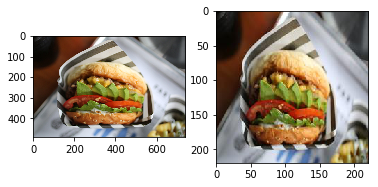

In [30]:
# jjung : 원본 이미지, resize 이미지 보기
from matplotlib.pyplot import imshow
from scipy.misc import imresize

index_image = 2 # 보고싶은 이미지 인덱스 입력
img_raw = cv2.imread(str(idxmatch.get(0)[index_image]) + ext)
img_resize = cv2.imread("resize" + str(index_image) + ext)

# Show the original image and resized image
plt.subplot(1, 2, 1)
plt.imshow(convertToRGB(img_raw))

# Show the tinted image
plt.subplot(1, 2, 2)
plt.imshow(convertToRGB(img_resize))

plt.show()


# Brute-force ORB

In [194]:
# 모범 이미지와 나머지 이미지들 간의 feature matching 정도를 기록할 빈 array: dist
dist = [] 

standard_idx = 2 # 모범 이미지 이름 (임의로 괜찮아 보이는 이미지 하나를 정한 것), 위의 버거의 경우 2번이미지가 괜찮았다.

img1 = cv2.imread('resize'+str(standard_idx)+ext) # 모범 이미지 설정

# shift
#sift=cv2.xfeatures2d.SIFT_create() # sift를 기준으로 사용해서 feature matching 정도를 계산할 예정
#(kp1, des1) = sift.detectAndCompute(img1, None) # 모범 이미지의 sift를 계산해서 저장

# orb
#orb = cv2.ORB_create(nfeatures=250)
orb = cv2.ORB_create(nfeatures=2500)
(kp1, des1) = orb.detectAndCompute(img1, None) # 모범 이미지의 orb를 계산해서 저장

#######################################################################################################

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)  # BFMatcher 만들어서 feature matching 시작
dist.append(10000)   # index 어긋남을 맞춰주기 위한 것
for i in range(1,len(idxmatch)): 
     
    if (i==standard_idx): # 2.jpeg가 비교의 기준인 모범 이미지이므로, 이 경우는 비교 안하고 가장 작은 값인 0 부여하고 넘어간다
        dist.append(0)
        continue
    
    img2 = cv2.imread('resize'+str(i)+ext)        # 비교 대상 이미지
    (kp2, des2) = orb.detectAndCompute(img2, None) # 비교 대상 이미지의 feature 추출

    matches = bf.match(des1,des2)  # 모범 이미지와 비교 이미지 match 시키기

    # distance 란?: 모범 이미지와 비교 이미지 사이의 match를 통한 비교를 통해 얻은 차이, 거리의 배열이고, 이 값이 작을 수록 거리가 좁다, 
    # 즉 비슷한 이미지 feature 를 가지고 있다는 뜻이다
    # 모범 이미지와 비교 대상이미지간의 match를 통해 나온 distance가 들어있는 matches 배열을 우선 sort 해서, 작은 값 순서로 나열한다
    matches = sorted(matches, key = lambda x:x.distance)
    
    # 각 이미지들의 matches 배열 중 작은 숫자 10개를 골라 평균을 내면: 이 값이 곧 해당하는 비교 이미지와 모범 이미지와의 거리를 대표하는 숫자가 된다
    # 전체 dist 배열에 저장 : 나중에 전체 dist 배열을 가지고 비교해서 모범 이미지와 가까운 이미지가 어떤 것들인지 알아본다
    sum=0
    for j in range(min(len(matches),10)): # 만약 두 이미지가 너무 달라서 matches가 10개도 안 될 경우를 대비해 min() 사용 
        sum=sum+matches[j].distance
    average=sum/min(len(matches),10)
    dist.append(average) 
#     sum=0
#     for j in range(len(matches)): 
#         sum=sum+matches[j].distance
#     average=sum/len(matches)
#     dist.append(average) 

In [195]:
index = list(range(len(dist))) # 이건 resize 이미지들의 인덱스를 따로 column 으로 저장하려는 것
dist=pd.DataFrame(dist)        # 앞서 계산해서 얻은 dist와 index를 dataframe으로 변환
index = pd.DataFrame(index)
dist = pd.concat([index, idxmatch,dist], axis=1, ignore_index=True) # 다 같이 column bind한다
# 이렇게 되면 1열: resize 이미지 번호, 2열: 원본 이미지 번호, 3열: 그 이미지의 match값 이 저장이 된다
dist.columns = ['resized_name', 'original_name','match'] # column 이름 설정
dist=dist[1:] # 우리들의 이미지들은 1부터 시작하므로  맨 첫번째 행은(dist[0])은 아무 값이 담겨있지 않은 행이 되어서 --> 그냥 지워버렸다

In [196]:
matching_list=dist.sort_values(by=['match']) # dist를 match가 작은값 부터 정렬해 준다

In [197]:
matching_list.head(10)

resized_name  original_name  match
2               2              2    0.0
324           324            330   34.9
387           387            393   35.3
668           668            677   35.3
6               6              6   35.6
307           307            313   35.6
474           474            481   35.7
48             48             48   36.0
226           226            232   36.4
696           696            705   36.5

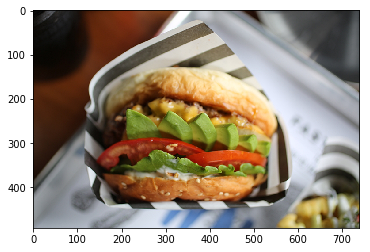

top 10:


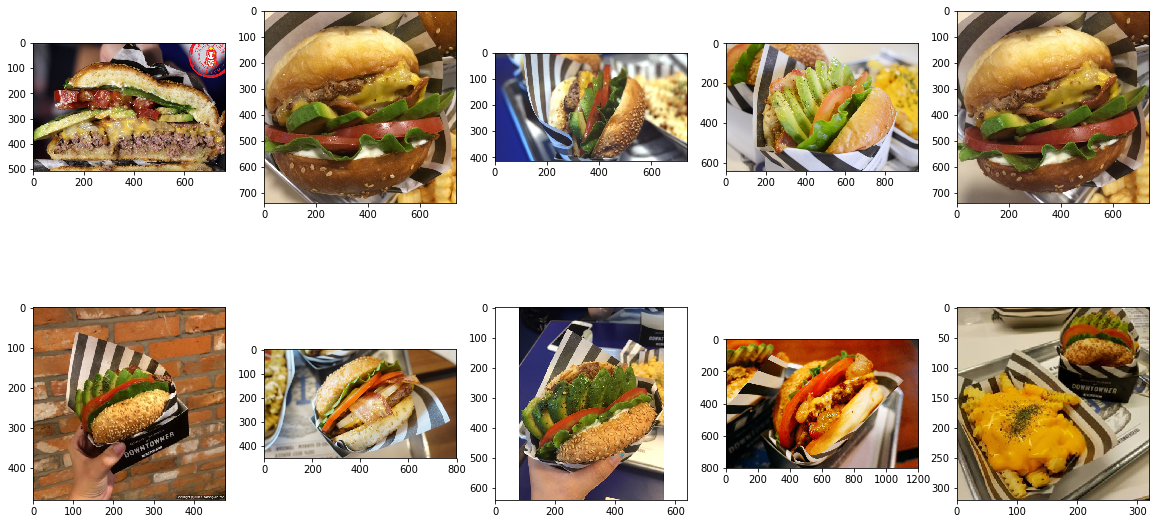

bottom 10:


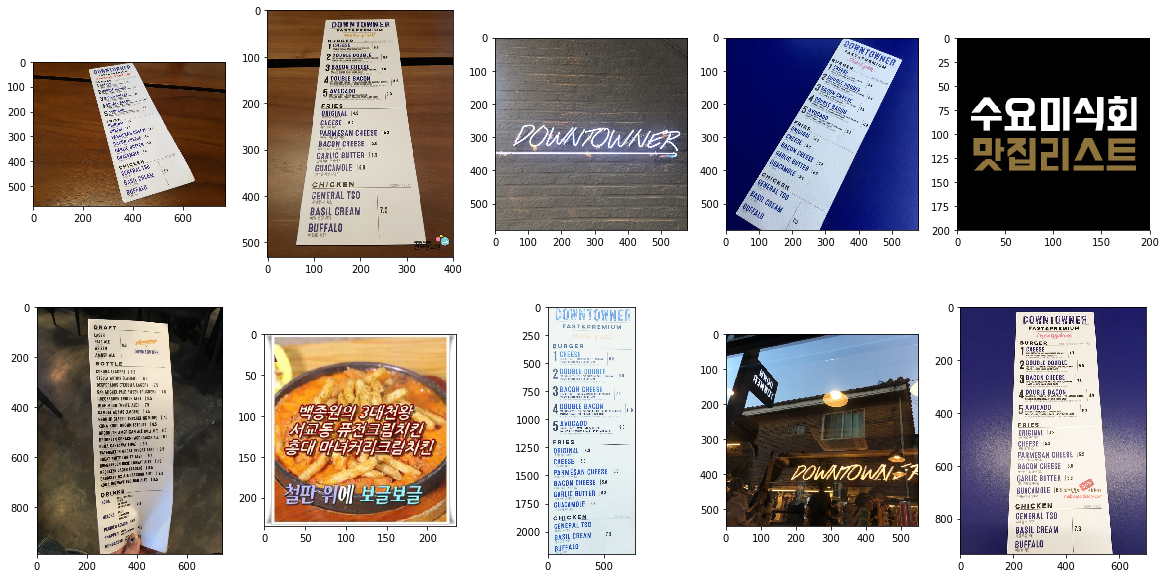

In [198]:
%matplotlib inline


# 확인 간편하게 하기 - standard image, top 5 , bottom 5 
matching_array = np.array(matching_list)
# show standard image
img_standard = cv2.imread(str(int(matching_array[0][0])) + ext)
plt.imshow(convertToRGB(img_standard))
plt.show()

n=10
# 가장 비슷한 사진 top 4
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
print('top 10:')
for top in range(1, n+1):
    plt.subplot(2, 5, top)
    img = cv2.imread(str(int(matching_array[top][1])) + ext)
    plt.imshow(convertToRGB(img))
plt.show()

# bottom 4
print('bottom 10:')
for bottom in range(1, n+1):
    plt.subplot(2,5,bottom)
    img = cv2.imread(str(int(matching_array[len(matching_list)-bottom][1])) + ext)
    plt.imshow(convertToRGB(img))
plt.show()

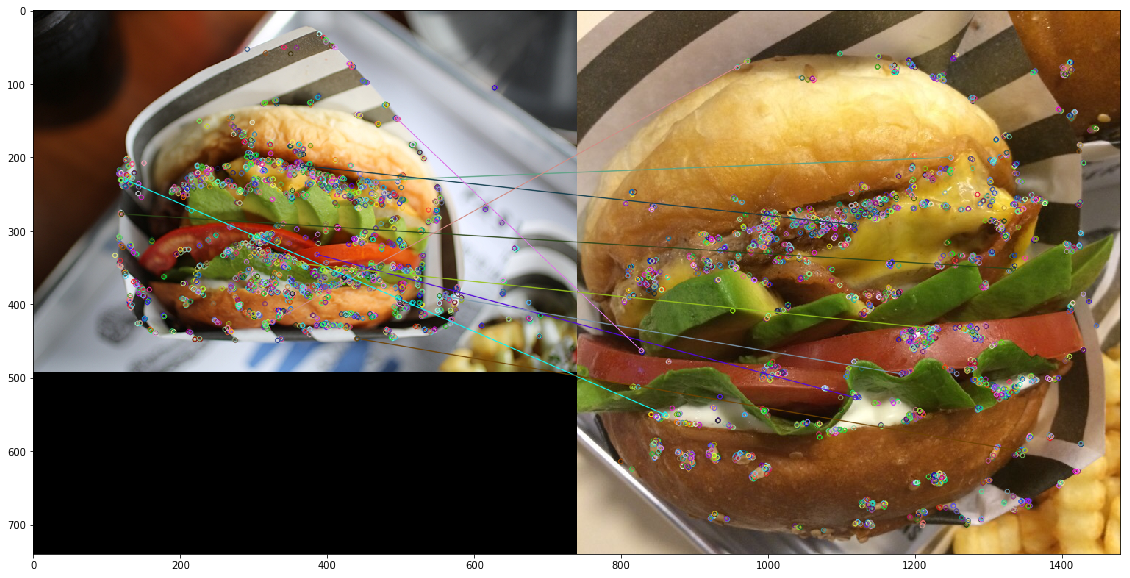

In [193]:
img1 = cv2.imread(str(standard_idx)+ext) # 모범 이미지 설정
orb = cv2.ORB_create(nfeatures=2500)
(kp1, des1) = orb.detectAndCompute(img1, None)

img2 = cv2.imread(str(int(matching_array[2][1])) + ext) # 가장 가깝다고 판단되는 사진과 한번 matching 그려보기
(kp2, des2) = orb.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], img1)
plt.imshow(convertToRGB(img3))
plt.show()


In [ ]:
img1 = cv2.imread(str(standard_idx)+ext) # 모범 이미지 설정
orb = cv2.ORB_create(nfeatures=2500)
(kp1, des1) = orb.detectAndCompute(img1, None)

img2 = cv2.imread(str(int(matching_array[2][1])) + ext) # 가장 가깝다고 판단되는 사진과 한번 matching 그려보기
(kp2, des2) = orb.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], img1)
plt.imshow(convertToRGB(img3))
plt.show()


In [94]:
matching_list.to_csv('_matching_list.csv', encoding='utf-8', index=False) # csv 파일로 저장해주기!!

# Ratio Test Matcher

In [256]:
dist = [] 

standard_idx = 2 
img1 = cv2.imread('resize'+str(standard_idx)+ext) # 모범 이미지 설정

# shift
# sift=cv2.xfeatures2d.SIFT_create() # sift를 기준으로 사용해서 feature matching 정도를 계산할 예정
# (kp1, des1) = sift.detectAndCompute(img1, None) # 모범 이미지의 sift를 계산해서 저장

# orb
FLANN_INDEX_KDTREE = 0

orb = cv2.ORB_create(nfeatures=2500)
(kp1, des1) = orb.detectAndCompute(img1, None)

#################################################

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
dist.append(10000)                           
for i in range(1,len(idxmatch)): 
    
    if (i==standard_idx):   
        dist.append(0)
        continue
    
    img2 = cv2.imread('resize'+str(i)+ext,0)
    (kp2, des2) = orb.detectAndCompute(img2, None) 

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2) # knnMatch적용 : ratio test 적용해 본다
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)
            
    matches = sorted(good, key = lambda x:x.distance)
    
#     sum=0
#     for j in range(len(matches)): 
#         sum=sum+matches[j].distance
#     average=sum/len(matches)
#     dist.append(average) 
    sum=0
    for j in range(min(len(matches),10)): # 만약 두 이미지가 너무 달라서 matches가 10개도 안 될 경우를 대비해 min() 사용 
        sum=sum+matches[j].distance
    average=sum/min(len(matches),10)
    dist.append(average) 

In [200]:
index = list(range(len(dist))) 
dist=pd.DataFrame(dist)
index = pd.DataFrame(index)
dist = pd.concat([index, idxmatch,dist], axis=1, ignore_index=True) 
dist.columns = ['resized_name', 'original_name','match'] 
dist=dist[1:]

In [201]:
matching_list=dist.sort_values(by=['match']) 

In [202]:
matching_list.head()

resized_name  original_name       match
2               2              2    0.000000
296           296            302  197.423161
524           524            531  204.049483
78             78             79  207.084888
107           107            110  207.342728

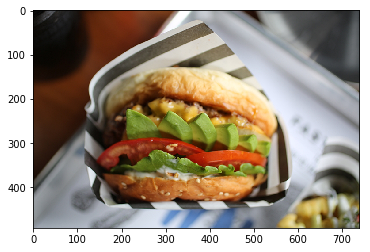

top 10:


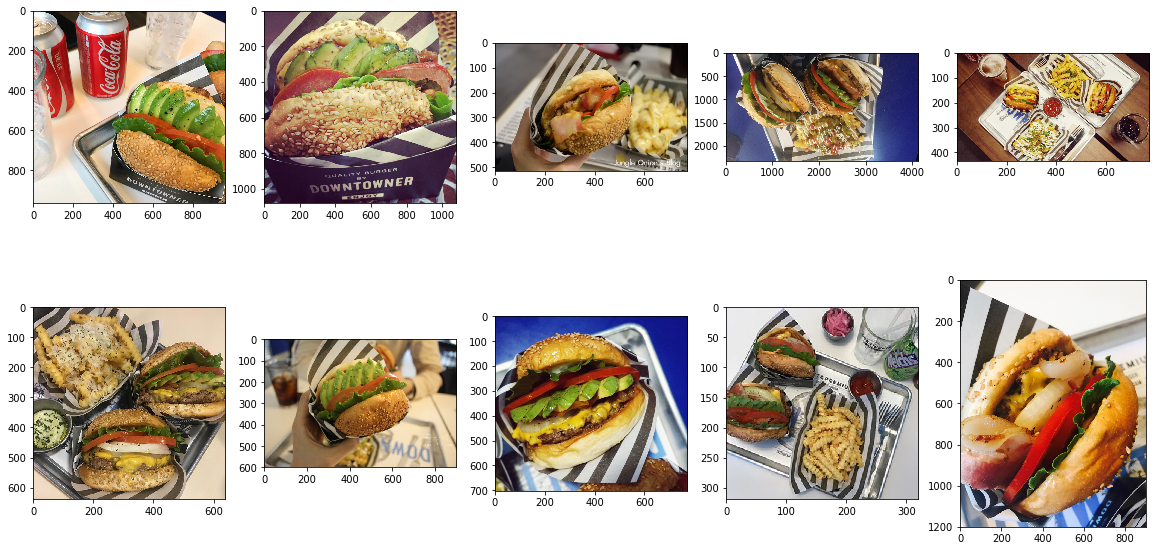

bottom 10:


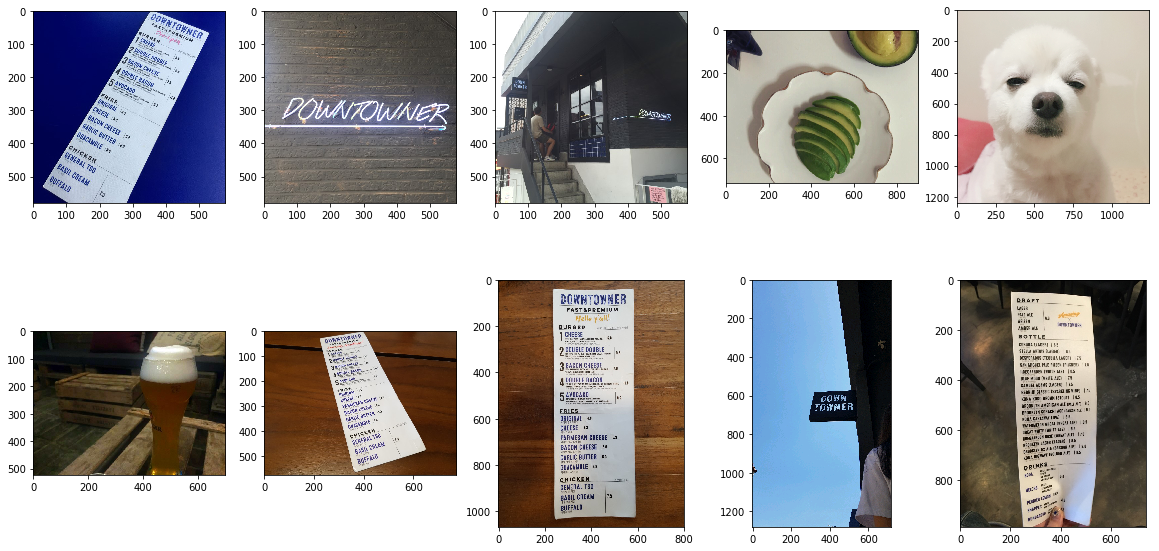

In [203]:
%matplotlib inline

# 확인 간편하게 하기 - standard image, top 5 , bottom 5 
matching_array = np.array(matching_list)
# show standard image
img_standard = cv2.imread(str(int(matching_array[0][0])) + ext)
plt.imshow(convertToRGB(img_standard))
plt.show()

n=10
# 가장 비슷한 사진 top 4
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
print('top 10:')
for top in range(1, n+1):
    plt.subplot(2, 5, top)
    img = cv2.imread(str(int(matching_array[top][1])) + ext)
    plt.imshow(convertToRGB(img))
plt.show()

# bottom 4
print('bottom 10:')
for bottom in range(1, n+1):
    plt.subplot(2,5,bottom)
    img = cv2.imread(str(int(matching_array[len(matching_list)-bottom][1])) + ext)
    plt.imshow(convertToRGB(img))
plt.show()

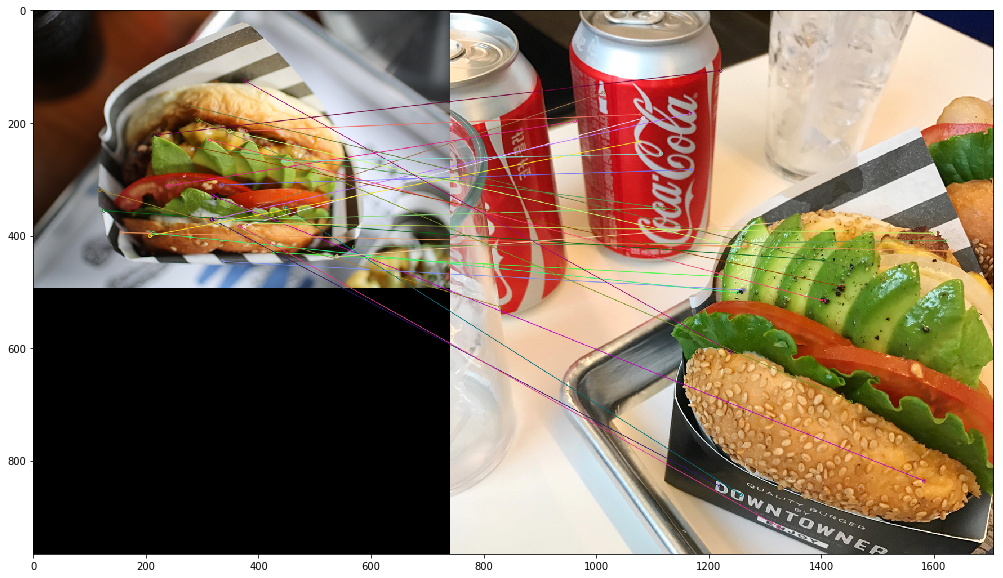

In [204]:
img1 = cv2.imread(str(standard_idx)+ext) # 모범 이미지 설정
orb = cv2.ORB_create(nfeatures=2500)
(kp1, des1) = orb.detectAndCompute(img1, None)

img2 = cv2.imread(str(int(matching_array[1][1])) + ext) # 가장 가깝다고 판단되는 사진과 한번 matching 그려보기
(kp2, des2) = orb.detectAndCompute(img2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# Draw first 10 matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,img1,flags=2)
plt.imshow(convertToRGB(img3))
plt.show()


# FLANN Based Matcher

In [249]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)

dist = [] 
standard_idx = 2 
img1 = cv2.imread('resize'+str(standard_idx)+ext) 



# shift
# sift=cv2.xfeatures2d.SIFT_create() # sift를 기준으로 사용해서 feature matching 정도를 계산할 예정
# (kp1, des1) = sift.detectAndCompute(img1, None) # 모범 이미지의 sift를 계산해서 저장

# orb

orb = cv2.ORB_create(nfeatures=2500)
(kp1, des1) = orb.detectAndCompute(img1, None) 

#################################################

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
dist.append(10000)                              
for i in range(1,len(idxmatch)): 
    
    if (i==standard_idx): 
        dist.append(0)
        continue
    
    img2 = cv2.imread('resize'+str(i)+ext,0)      
    (kp2, des2) = orb.detectAndCompute(img2, None) 
    
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    
    # ratio test as per Lowe's paper
    try:
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
    except:
        pass
    
    matches = sorted(good, key = lambda x:x.distance)
    
    for j in range(min(len(matches),10)): # 만약 두 이미지가 너무 달라서 matches가 10개도 안 될 경우를 대비해 min() 사용 
        sum=sum+matches[j].distance
    if(len(matches)==0):
        dist.append(1000000000000)
    else:
        average=sum/min(len(matches),10)
        dist.append(average) 

In [250]:
index = list(range(len(dist))) 
dist=pd.DataFrame(dist)       
index = pd.DataFrame(index)
dist = pd.concat([index, idxmatch,dist], axis=1, ignore_index=True) 
dist.columns = ['resized_name', 'original_name','match'] 
dist=dist[1:]

In [251]:
matching_list=dist.sort_values(by=['match']) 

In [254]:
matching_list.head()

resized_name  original_name    match
2               2              2      0.0
10             10             10  51878.9
40             40             40  52491.8
55             55             55  52806.5
127           127            130  54146.3

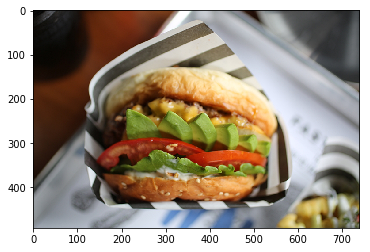

top 10:


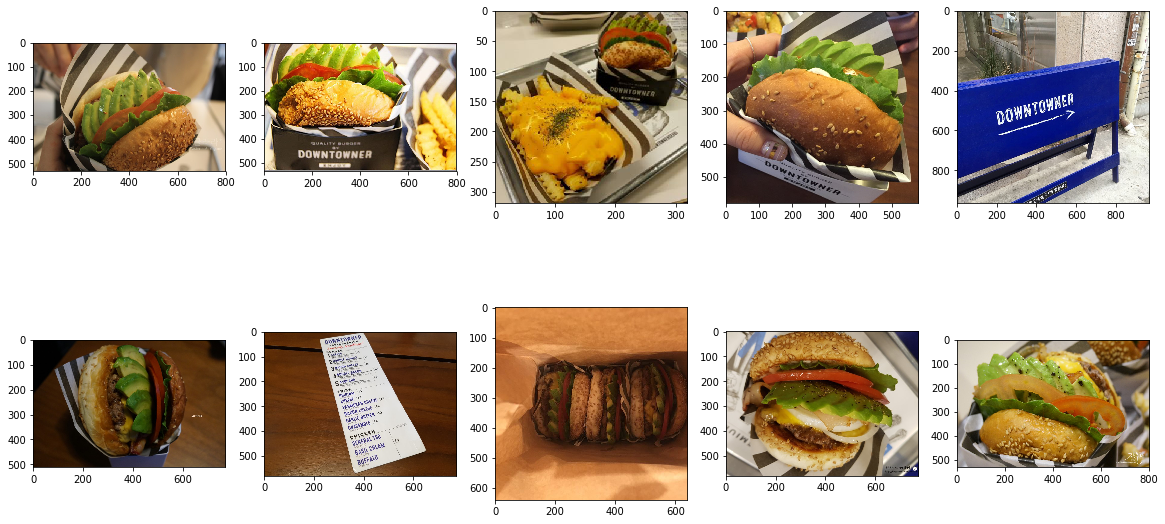

bottom 10:


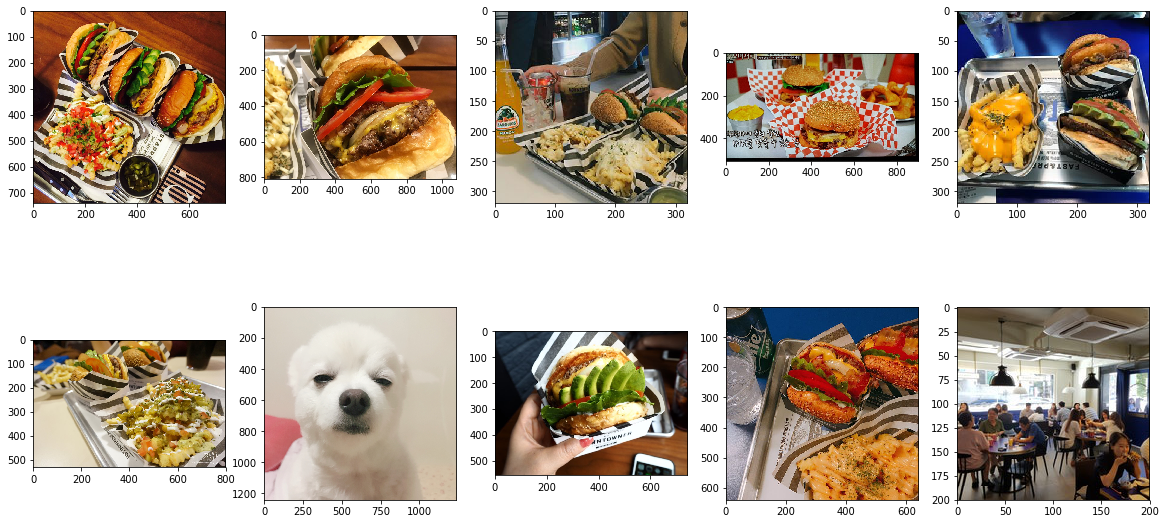

In [255]:
%matplotlib inline

# 확인 간편하게 하기 - standard image, top 5 , bottom 5 
matching_array = np.array(matching_list)
# show standard image
img_standard = cv2.imread(str(int(matching_array[0][0])) + ext)
plt.imshow(convertToRGB(img_standard))
plt.show()

n=10
# 가장 비슷한 사진 top 4
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
print('top 10:')
for top in range(1, n+1):
    plt.subplot(2, 5, top)
    img = cv2.imread(str(int(matching_array[top][1])) + ext)
    plt.imshow(convertToRGB(img))
plt.show()

# bottom 4
print('bottom 10:')
for bottom in range(1, n+1):
    plt.subplot(2,5,bottom)
    img = cv2.imread(str(int(matching_array[len(matching_list)-bottom][1])) + ext)
    plt.imshow(convertToRGB(img))
plt.show()

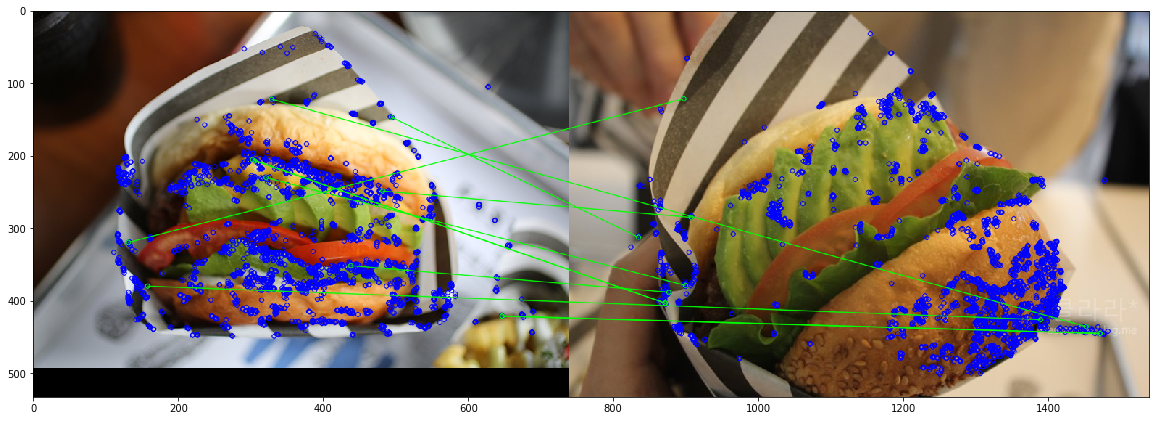

In [258]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)

img1 = cv2.imread(str(standard_idx)+ext) # 모범 이미지 설정
orb = cv2.ORB_create(nfeatures=2500)
(kp1, des1) = orb.detectAndCompute(img1, None)

img2 = cv2.imread(str(int(matching_array[1][1])) + ext) # 가장 가깝다고 판단되는 사진과 한번 matching 그려보기
(kp2, des2) = orb.detectAndCompute(img2,None)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(convertToRGB(img3))
plt.show()
